# Library Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import VarianceThreshold
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

# Import Datasets

In [2]:
train_csv_url = "/content/drive/MyDrive/#Semester07/CS4622/ML Project/speech-based-classification-layer-9/train.csv"
valid_csv_url = "/content/drive/MyDrive/#Semester07/CS4622/ML Project/speech-based-classification-layer-9/valid.csv"
test_csv_url = "/content/drive/MyDrive/#Semester07/CS4622/ML Project/speech-based-classification-layer-9/test.csv"

train_data = pd.read_csv(train_csv_url)
valid_data = pd.read_csv(valid_csv_url)
test_data = pd.read_csv(test_csv_url)

print("Train data:")
print(train_data.head())
print("Valid data:")
print(valid_data.head())
print("Test data:")
print(test_data.head())

Train data:
   feature_1  feature_2  feature_3  feature_4  feature_5  feature_6  \
0   0.019301   0.059756   0.081375   0.057481  -0.068440  -0.165913   
1   0.049741   0.090030   0.035118  -0.013676  -0.194317  -0.101763   
2   0.019212   0.087779   0.093907  -0.033738  -0.141409  -0.062881   
3   0.070283   0.049040   0.042126   0.122637  -0.056964  -0.113700   
4   0.028864   0.165634   0.016302   0.036117  -0.028871  -0.147748   

   feature_7  feature_8  feature_9  feature_10  ...  feature_763  feature_764  \
0   0.035643  -0.091138   0.021688    0.057158  ...    -0.035576     0.127319   
1   0.085875  -0.081317   0.112418    0.120523  ...     0.020538     0.058968   
2  -0.071402  -0.006599   0.020372   -0.027777  ...     0.119645    -0.040861   
3   0.108454   0.051336   0.086610    0.141578  ...    -0.124494    -0.169225   
4   0.053180   0.025071  -0.004200   -0.022183  ...    -0.124862     0.044907   

   feature_765  feature_766  feature_767  feature_768  label_1  label_2  \

# Data Visualization

In [ ]:
def visualize_label(y, title, x_title, y_title='Number of entries'):
  unique_classes, class_counts = np.unique(y, return_counts=True)
  plt.bar(unique_classes, class_counts)
  plt.xlabel(x_title)
  plt.ylabel(y_title)
  plt.title(title)
  plt.show()

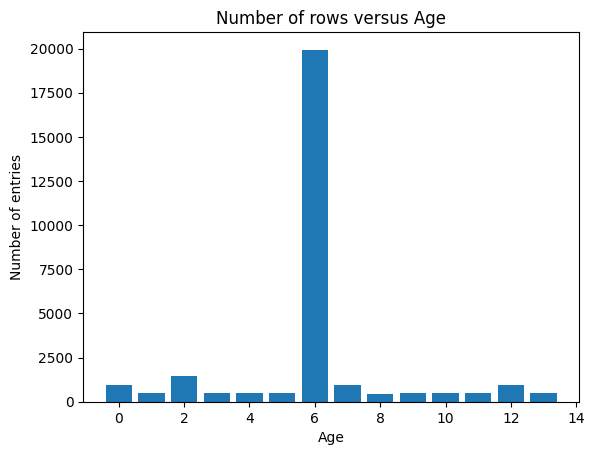

In [ ]:
visualize_label(train_data['label_4'], "Number of rows versus Age","Age")

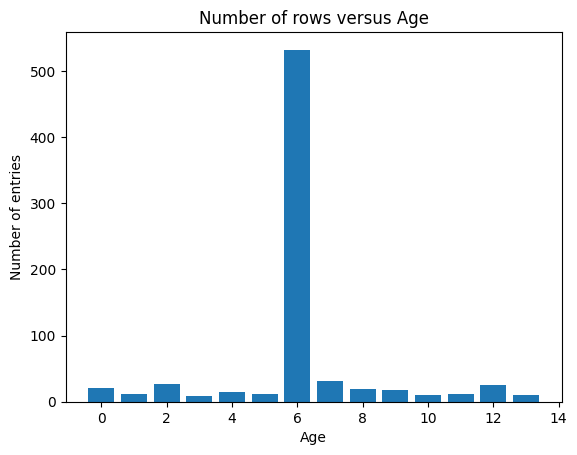

In [ ]:
visualize_label(valid_data['label_4'], "Number of rows versus Age","Age")

# Outlier Detection and Removal

In [3]:
from scipy.stats import norm

def visualize_label_norm(y, title, x_title, y_title='Number of entries'):
  unique_classes, class_counts = np.unique(y, return_counts=True)
  plt.bar(unique_classes, class_counts)
  plt.xlabel(x_title)
  plt.ylabel(y_title)
  plt.title(title)

  rng = np.arange(train_data["label_4"].min(), train_data["label_4"].max(), 0.1)
  plt.plot(rng, norm.pdf(rng,train_data["label_4"].mean(),train_data["label_4"].std()))
  plt.show()

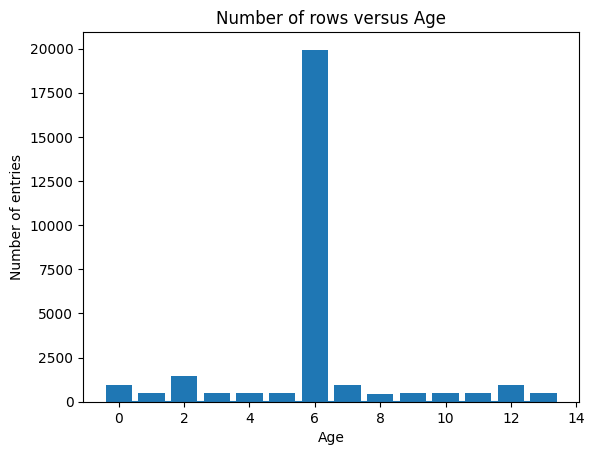

In [4]:
visualize_label_norm(train_data['label_4'], "Number of rows versus Age","Age")

In [5]:
train_data['zscore'] = ( train_data["label_4"] - train_data["label_4"].mean() ) / train_data["label_4"].std()
outliers = train_data[(train_data.zscore<-3) | (train_data.zscore>3)]
outliers.shape

(0, 773)

No outliers to remove

# Train without Feaure Reduction

In [6]:
print(f"train_data dataset shape {train_data.shape}")
print(f"# of missing values {train_data['label_4'].isna().sum()}")
print(f"# of labels {train_data['label_4'].value_counts().shape[0]}")
print(f"label summary\n{train_data['label_4'].value_counts()}")

train_data dataset shape (28520, 773)
# of missing values 0
# of labels 14
label summary
6     19938
2      1449
0       955
12      954
7       938
13      482
1       481
11      480
10      480
3       479
5       478
9       472
4       469
8       465
Name: label_4, dtype: int64


In [7]:
train_data.dropna(subset=['label_4'], inplace=True)
print(f"train_data dataset shape {train_data.shape}")

train_data dataset shape (28520, 773)


Feature Enginering

*   Label_4 has no missing values
*   Label_4 has 14 unique classes
*   Using one-hot encoding for multilabel classification



In [8]:
label_4 = train_data['label_4'].values.reshape(-1, 1)
ohe = OneHotEncoder(handle_unknown='ignore', sparse_output=False).fit(label_4)
print(ohe.categories_)

label_4 = ohe.transform(label_4)
print(label_4)

[array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13])]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [9]:
X_train, X_test, y_train, y_test = train_test_split(train_data.iloc[:, :768], label_4, test_size=0.2, stratify=label_4, random_state=2023)

In [10]:
X_train_tensors = torch.tensor(X_train.iloc[:, :].values, dtype=torch.float32)
print(X_train_tensors.shape)

X_test_tensors = torch.tensor(X_test.iloc[:, :].values, dtype=torch.float32)
print(X_test_tensors.shape)

torch.Size([22816, 768])
torch.Size([5704, 768])


## Define the Model

In [11]:
class AccentClassifier(nn.Module):
    def __init__(self, dropout_prob=0.5, weight_decay=1e-5):
        super(AccentClassifier, self).__init__()
        self.linear1 = nn.Linear(768, 512)
        self.linear2 = nn.Linear(512, 256)
        self.linear3 = nn.Linear(256, 128)
        self.linear4 = nn.Linear(128, 14)

        # Set weight_decay for regularization
        self.weight_decay = weight_decay

    def forward(self, tensors):
        output_l1 = torch.relu(self.linear1(tensors))
        output_l2 = torch.relu(self.linear2(output_l1))
        output_l3 = torch.relu(self.linear3(output_l2))
        output_l4 = self.linear4(output_l3)
        return output_l4

    def l2_regularization_loss(self):
        # Calculate L2 regularization loss for linear layers
        l2_loss = 0.0
        for param in self.parameters():
            if param.requires_grad:
                l2_loss += torch.norm(param, 2)
        return self.weight_decay * l2_loss

## Train the model

In [12]:
# Create an instance of the AccentClassifier model
accentClassifier = AccentClassifier()

# Define a cross-entropy loss function
criterion = nn.CrossEntropyLoss()

# Create a DataLoader for batching
batch_size = 128
dataset = TensorDataset(X_train_tensors, torch.tensor(y_train))
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# Define an optimizer
optimizer = torch.optim.Adam(accentClassifier.parameters(), lr=0.001)

# Define early stopping parameters
patience = 25
best_validation_accuracy = 0
no_improvement_counter = 0

# Training loop
epochs = 1000
for epoch in range(epochs):

    for inputs, targets in dataloader:
        optimizer.zero_grad()
        outputs = accentClassifier(inputs)

        ce_loss = criterion(outputs, targets)
        l2_loss = accentClassifier.l2_regularization_loss()

        total_loss = ce_loss + l2_loss

        total_loss.backward()
        optimizer.step()

    # Validation step (evaluate on validation dataset)
    with torch.no_grad():
        accentClassifier.eval()
        y_test_pred = accentClassifier(X_test_tensors)
        ce = criterion(y_test_pred, torch.tensor(y_test))
        acc = (torch.argmax(y_test_pred, 1) == torch.argmax(torch.tensor(y_test), 1)).float().mean()
        accentClassifier.train()

    print(f"Epoch {epoch} validation: Cross-entropy={float(ce)}, Accuracy={float(acc)}")

    # Check for early stopping
    if acc > best_validation_accuracy:
        best_validation_accuracy = acc
        no_improvement_counter = 0
        # Save the trained best model if needed
        torch.save(accentClassifier.state_dict(), 'accentClassifier_model.pth')
    else:
        no_improvement_counter += 1

    # If no improvement for 'patience' consecutive epochs, stop training
    if no_improvement_counter >= patience:
        print("Early stopping triggered. Training stopped.")
        break

Epoch 0 validation: Cross-entropy=1.073754865974887, Accuracy=0.7096773982048035
Epoch 1 validation: Cross-entropy=0.5958169398254604, Accuracy=0.8115357756614685
Epoch 2 validation: Cross-entropy=0.36499404908010824, Accuracy=0.8855189085006714
Epoch 3 validation: Cross-entropy=0.2964433385078798, Accuracy=0.9074333906173706
Epoch 4 validation: Cross-entropy=0.2466826390818568, Accuracy=0.9218092560768127
Epoch 5 validation: Cross-entropy=0.23618470531694274, Accuracy=0.9316269159317017
Epoch 6 validation: Cross-entropy=0.2260903740880056, Accuracy=0.9363604784011841
Epoch 7 validation: Cross-entropy=0.17496785266384565, Accuracy=0.9498597383499146
Epoch 8 validation: Cross-entropy=0.1770240887417256, Accuracy=0.9426718354225159
Epoch 9 validation: Cross-entropy=0.17033058118647026, Accuracy=0.9531907439231873
Epoch 10 validation: Cross-entropy=0.15768208535865946, Accuracy=0.95652174949646
Epoch 11 validation: Cross-entropy=0.17545596293180832, Accuracy=0.950560986995697
Epoch 12 val

In [13]:
# Create an instance of the model
accentClassifier = AccentClassifier()

# Load the saved model state dictionary
accentClassifier.load_state_dict(torch.load('/content/drive/Shareddrives/test/ML _Project/accentClassifier_model.pth'))

# Validation step (evaluate on validation dataset)
with torch.no_grad():
    accentClassifier.eval()
    y_test_pred = accentClassifier(X_test_tensors)
    ce = criterion(y_test_pred, torch.tensor(y_test))
    acc = (torch.argmax(y_test_pred, 1) == torch.argmax(torch.tensor(y_test), 1)).float().mean()

print(f"Best model validation: Cross-entropy={float(ce)}, Accuracy={float(acc)}")

Best model validation: Cross-entropy=0.1815718453726566, Accuracy=0.9738779664039612


## Evaluation of the Model

In [14]:
valid_data.dropna(subset=['label_4'], inplace=True)
print(f"valid_data dataset shape {valid_data.shape}")

valid_data dataset shape (750, 772)


In [15]:
label_4_eval = valid_data['label_4'].values.reshape(-1, 1)
ohe = OneHotEncoder(handle_unknown='ignore', sparse_output=False).fit(label_4_eval)
print(ohe.categories_)

label_4_eval = ohe.transform(label_4_eval)
print(label_4_eval)

[array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13])]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [16]:
# Set your model to evaluation mode
accentClassifier.eval()

X_valid_tensors = torch.tensor(valid_data.iloc[:, :768].values, dtype=torch.float32)
print(X_valid_tensors.shape)

y_pred = accentClassifier(X_valid_tensors)
ce = criterion(y_pred, torch.tensor(label_4_eval))
acc = (torch.argmax(y_pred, 1) == torch.argmax(torch.tensor(label_4_eval), 1)).float().mean()
print(f"Cross-entropy={float(ce)}, Test Accuracy={float(acc)}")

torch.Size([750, 768])
Cross-entropy=0.18314933168869182, Test Accuracy=0.9773333072662354


In [17]:
valid_data_c = valid_data.copy()

y_pred_one_hot = ohe.inverse_transform(y_pred.detach().numpy())
valid_data_c["label_4_pred"] = pd.DataFrame(y_pred_one_hot, columns=["label_4_pred"])

In [18]:
valid_data_c.iloc[:, 771:].head(100)

,label_4,label_4_pred
0,6,6
1,6,6
2,6,6
3,6,6
4,6,6
...,...,...
95,1,1
96,1,1
97,1,1
98,6,6


In [19]:
y_pred_labels = torch.argmax(y_pred, axis=1).numpy()
label_4_np = torch.argmax(torch.tensor(label_4_eval), axis=1).numpy()

confusion = confusion_matrix(label_4_np, y_pred_labels)
print(classification_report(label_4_np, y_pred_labels))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        21
           1       0.92      1.00      0.96        11
           2       0.96      0.85      0.90        27
           3       0.89      1.00      0.94         8
           4       1.00      0.87      0.93        15
           5       0.92      1.00      0.96        11
           6       0.99      0.99      0.99       532
           7       0.89      1.00      0.94        32
           8       1.00      1.00      1.00        19
           9       0.94      0.88      0.91        17
          10       1.00      1.00      1.00        10
          11       1.00      0.91      0.95        11
          12       0.96      0.92      0.94        26
          13       1.00      0.90      0.95        10

    accuracy                           0.98       750
   macro avg       0.96      0.95      0.95       750
weighted avg       0.98      0.98      0.98       750



In [20]:
accuracy_score(label_4_np, y_pred_labels)

0.9773333333333334

## Fixing class imbalance

In [21]:
from imblearn.over_sampling import SMOTE

# transform the dataset
oversample = SMOTE()
X_train_balanced, y_train_balanced = oversample.fit_resample(X_train, y_train)

print(X_train_balanced.shape)
print(y_train_balanced.shape)

(223300, 768)
(223300, 14)


In [22]:
y_train_balanced

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 1],
       [0, 0, 0, ..., 0, 0, 1],
       [0, 0, 0, ..., 0, 0, 1]])

In [ ]:
# Create an instance of the AccentClassifier model
accentClassifierOverSample = AccentClassifier()

# Define a cross-entropy loss function
criterion = nn.CrossEntropyLoss()

# Create a DataLoader for batching
batch_size = 128
dataset = TensorDataset(torch.tensor(X_train_balanced.values, dtype=torch.float32), torch.tensor(y_train_balanced))
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# Define an optimizer
optimizer = torch.optim.Adam(accentClassifierOverSample.parameters(), lr=0.001)

# Define early stopping parameters
patience = 25
best_validation_accuracy = 0
no_improvement_counter = 0

# Training loop
epochs = 1000
for epoch in range(epochs):

    for inputs, targets in dataloader:
        optimizer.zero_grad()
        outputs = accentClassifierOverSample(inputs)
        ce_loss = criterion(outputs, targets.float())
        l2_loss = accentClassifierOverSample.l2_regularization_loss()

        total_loss = ce_loss + l2_loss

        total_loss.backward()
        optimizer.step()

    # Validation step (evaluate on validation dataset)
    with torch.no_grad():
        accentClassifierOverSample.eval()
        y_test_pred = accentClassifierOverSample(X_test_tensors)
        ce = criterion(y_test_pred, torch.tensor(y_test))
        acc = (torch.argmax(y_test_pred, 1) == torch.argmax(torch.tensor(y_test), 1)).float().mean()
        accentClassifierOverSample.train()

    print(f"Epoch {epoch} validation: Cross-entropy={float(ce)}, Accuracy={float(acc)}")

    # Check for early stopping
    if acc > best_validation_accuracy:
        best_validation_accuracy = acc
        no_improvement_counter = 0
        # Save the trained best model if needed
        torch.save(accentClassifierOverSample.state_dict(), 'accentClassifierOverSample_model.pth')
    else:
        no_improvement_counter += 1

    # If no improvement for 'patience' consecutive epochs, stop training
    if no_improvement_counter >= patience:
        print("Early stopping triggered. Training stopped.")
        break

Epoch 0 validation: Cross-entropy=0.30870594392967793, Accuracy=0.9023492336273193
Epoch 1 validation: Cross-entropy=0.3187922894726072, Accuracy=0.9055048823356628
Epoch 2 validation: Cross-entropy=0.22696799218085975, Accuracy=0.9414445757865906
Epoch 3 validation: Cross-entropy=0.21439148299485217, Accuracy=0.9477559328079224
Epoch 4 validation: Cross-entropy=0.2275793636776225, Accuracy=0.9510869383811951
Epoch 5 validation: Cross-entropy=0.402837756727402, Accuracy=0.9063814878463745
Epoch 6 validation: Cross-entropy=0.237218363464584, Accuracy=0.9540673494338989
Epoch 7 validation: Cross-entropy=0.22784394463519989, Accuracy=0.9623071551322937
Epoch 8 validation: Cross-entropy=0.2930504012759609, Accuracy=0.9430224299430847
Epoch 9 validation: Cross-entropy=0.25445585373042323, Accuracy=0.9549438953399658
Epoch 10 validation: Cross-entropy=0.40804356899137206, Accuracy=0.9088358879089355
Epoch 11 validation: Cross-entropy=0.24390743564557818, Accuracy=0.9537166953086853
Epoch 12 

In [ ]:
# Create an instance of the model
accentClassifierOverSample = AccentClassifier()

# Load the saved model state dictionary
accentClassifierOverSample.load_state_dict(torch.load('/content/drive/Shareddrives/test/ML _Project/accentClassifierOverSample_model.pth'))

# Validation step (evaluate on validation dataset)
with torch.no_grad():
    accentClassifierOverSample.eval()
    y_test_pred = accentClassifierOverSample(X_test_tensors)
    ce = criterion(y_test_pred, torch.tensor(y_test))
    acc = (torch.argmax(y_test_pred, 1) == torch.argmax(torch.tensor(y_test), 1)).float().mean()

print(f"Best model validation: Cross-entropy={float(ce)}, Accuracy={float(acc)}")

We get better results without oversampling

## Get Test Results

In [ ]:
# Set your model to evaluation mode
accentClassifier.eval()

X_t_tensors = torch.tensor(test_data.iloc[:, :768].values, dtype=torch.float32)
print(X_t_tensors.shape)

y_pred_t = accentClassifier(X_t_tensors)
print(y_pred_t.shape)


In [ ]:
y_pred_one_hot = ohe.inverse_transform(y_pred_t.detach().numpy())
test_data["label_4"] = pd.DataFrame(y_pred_one_hot, columns=["label_4"])

In [ ]:
test_data.head()

In [ ]:
file_path = "/content/drive/MyDrive/#Semester07/CS4622/ML Project/speech-based-classification-layer-9/label_4.csv"

# Save the DataFrame to a CSV file
test_data.to_csv(file_path, index=False)

# Train with Feature Engineering

In [ ]:
data_features = train_data.iloc[:, :768]

## Drop Constant Features Using Variance Threshold

In [ ]:
var_thres=VarianceThreshold(threshold=0)
var_thres.fit(data_features)

VarianceThreshold(threshold=0)

In [ ]:
constant_columns = [column for column in data_features.columns
                    if column not in data_features.columns[var_thres.get_support()]]

print(constant_columns)

[]


There is no constant columns

## Drop Features Using Pearson Correlation

In [ ]:
data_features.corr()

,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,feature_10,...,feature_759,feature_760,feature_761,feature_762,feature_763,feature_764,feature_765,feature_766,feature_767,feature_768
feature_1,1.000000,0.065348,-0.039416,0.116528,0.108225,-0.163679,0.131004,-0.073198,-0.045476,-0.120560,...,-0.225724,0.290177,0.015310,0.144664,-0.110313,-0.040330,0.132620,0.032706,0.035296,-0.039317
feature_2,0.065348,1.000000,0.043611,0.068624,-0.278709,0.052155,-0.267946,-0.214403,-0.235840,-0.056829,...,-0.150852,-0.096604,0.287950,-0.099087,0.269144,0.005612,-0.068710,-0.204834,-0.350866,0.162593
feature_3,-0.039416,0.043611,1.000000,-0.185437,-0.313107,-0.103496,-0.214606,-0.185952,0.155197,0.011407,...,-0.248988,-0.162378,-0.024814,0.162806,0.231606,0.204807,0.133835,-0.063354,0.159975,0.217143
feature_4,0.116528,0.068624,-0.185437,1.000000,0.096349,-0.220416,0.194002,0.027816,-0.144393,-0.148927,...,0.135598,0.071113,-0.084978,-0.166751,-0.220446,0.103712,0.100221,0.006758,0.034292,-0.128138
feature_5,0.108225,-0.278709,-0.313107,0.096349,1.000000,0.021056,0.325761,-0.000900,0.038333,-0.116997,...,-0.020572,0.024932,-0.202849,0.031865,-0.371326,-0.087327,-0.063512,0.016875,-0.031415,-0.203071
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
feature_764,-0.040330,0.005612,0.204807,0.103712,-0.087327,-0.174192,0.122454,0.012446,0.199985,0.171440,...,0.075743,0.065512,-0.313912,-0.196618,-0.114188,1.000000,0.208730,0.181622,0.405485,-0.009266
feature_765,0.132620,-0.068710,0.133835,0.100221,-0.063512,-0.345465,-0.002038,0.005804,0.053829,-0.116723,...,-0.103060,0.180543,-0.010908,-0.076788,0.228983,0.208730,1.000000,-0.204636,0.278358,-0.172730
feature_766,0.032706,-0.204834,-0.063354,0.006758,0.016875,-0.233690,0.282928,-0.105139,0.097498,0.391228,...,0.096985,0.293527,-0.266795,0.168379,-0.486373,0.181622,-0.204636,1.000000,0.388446,-0.065182
feature_767,0.035296,-0.350866,0.159975,0.034292,-0.031415,-0.350340,0.185927,0.045446,0.113304,0.265687,...,0.115303,0.274362,-0.343106,0.081103,-0.327079,0.405485,0.278358,0.388446,1.000000,-0.132940


In [ ]:
# Using Pearson Correlation
plt.figure(figsize=(12,10))
cor = data_features.corr()
sns.heatmap(cor, annot=True, cmap=plt.cm.CMRmap_r)
plt.show()

In [ ]:
def correlation(dataset, threshold):
    correlated_pairs = set()
    corr_matrix = dataset.corr()
    for i in range(len(corr_matrix.columns)):
        for j in range(i):
            if abs(corr_matrix.iloc[i, j]) > threshold: # we are interested in absolute coeff value
                colname = corr_matrix.columns[i]  # getting the name of column
                rowname = corr_matrix.index[j]  # getting the name of row
                correlated_pairs.add((rowname, colname))
    return correlated_pairs

def get_less_correlated_features(correlated_pairs, dataset, target_column):
    less_correlated_features = {}

    for (feature1, feature2) in correlated_pairs:
        corr1 = dataset[feature1].corr(dataset[target_column])
        corr2 = dataset[feature2].corr(dataset[target_column])

        if abs(corr1) < abs(corr2):
            correlated_pair = frozenset((feature1, feature2))  # Use a frozenset as the key
            less_correlated_features[correlated_pair] = feature1
        else:
            correlated_pair = frozenset((feature1, feature2))  # Use a frozenset as the key
            less_correlated_features[correlated_pair] = feature2

    return less_correlated_features

In [ ]:
corr_feature_pairs = correlation(data_features, 0.9)
corr_feature_pairs

{('feature_210', 'feature_609')}

In [ ]:
less_correlated_features = get_less_correlated_features(corr_feature_pairs, train_data, "label_4")
less_correlated_features

{frozenset({'feature_210', 'feature_609'}): 'feature_609'}

In [ ]:
corr_features = set(less_correlated_features.values())
corr_features

{'feature_609'}

In [ ]:
new_features = data_features.drop(corr_features,axis=1)

In [ ]:
print(data_features.shape)
print(new_features.shape)

(28520, 768)
(28520, 767)


## Train the model

In [ ]:
class AccentClassifierAfter(nn.Module):
    def __init__(self, dropout_prob=0.5, weight_decay=1e-5):
        super(AccentClassifierAfter, self).__init__()
        self.linear1 = nn.Linear(767, 512)
        self.linear2 = nn.Linear(512, 256)
        self.linear3 = nn.Linear(256, 128)
        self.linear4 = nn.Linear(128, 14)

        # Set weight_decay for regularization
        self.weight_decay = weight_decay

    def forward(self, tensors):
        output_l1 = torch.relu(self.linear1(tensors))
        output_l2 = torch.relu(self.linear2(output_l1))
        output_l3 = torch.relu(self.linear3(output_l2))
        output_l4 = self.linear4(output_l3)
        return output_l4

    def l2_regularization_loss(self):
        # Calculate L2 regularization loss for linear layers
        l2_loss = 0.0
        for param in self.parameters():
            if param.requires_grad:
                l2_loss += torch.norm(param, 2)
        return self.weight_decay * l2_loss

In [ ]:
label_4 = train_data['label_4'].values.reshape(-1, 1)
ohe = OneHotEncoder(handle_unknown='ignore', sparse_output=False).fit(label_4)
print(ohe.categories_)

label_4 = ohe.transform(label_4)
print(label_4)

[array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13])]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [ ]:
X_train_after, X_test_after, y_train_after, y_test_after = train_test_split(new_features, label_4, test_size=0.2, stratify=label_4, random_state=2023)

X_train_tensors_after = torch.tensor(X_train_after.values, dtype=torch.float32)
print(X_train_tensors_after.shape)


X_test_tensors_after = torch.tensor(X_test_after.values, dtype=torch.float32)
print(X_test_tensors_after.shape)

torch.Size([22816, 767])
torch.Size([5704, 767])


In [ ]:
y_train_after.shape

(22816, 14)

In [ ]:
# Create an instance of the AccentClassifierAfter model
accentClassifierAfter = AccentClassifierAfter()

# Define a cross-entropy loss function
criterion = nn.CrossEntropyLoss()

# Create a DataLoader for batching
batch_size = 128
dataset = TensorDataset(X_train_tensors_after, torch.tensor(y_train_after))
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# Define an optimizer
optimizer = torch.optim.Adam(accentClassifierAfter.parameters(), lr=0.001)

# Define early stopping parameters
patience = 25
best_validation_accuracy = 0
no_improvement_counter = 0

# Training loop
epochs = 1000
for epoch in range(epochs):

    for inputs, targets in dataloader:
        optimizer.zero_grad()
        outputs = accentClassifierAfter(inputs)

        ce_loss = criterion(outputs, targets)
        l2_loss = accentClassifierAfter.l2_regularization_loss()

        total_loss = ce_loss + l2_loss

        total_loss.backward()
        optimizer.step()

    # Validation step (evaluate on validation dataset)
    with torch.no_grad():
        accentClassifierAfter.eval()
        y_test_pred_after = accentClassifierAfter(X_test_tensors_after)
        ce = criterion(y_test_pred_after, torch.tensor(y_test_after))
        acc = (torch.argmax(y_test_pred_after, 1) == torch.argmax(torch.tensor(y_test_after), 1)).float().mean()
        accentClassifierAfter.train()

    print(f"Epoch {epoch} validation: Cross-entropy={float(ce)}, Accuracy={float(acc)}")

    # Check for early stopping
    if acc > best_validation_accuracy:
        best_validation_accuracy = acc
        no_improvement_counter = 0
        # Save the trained best model if needed
        torch.save(accentClassifierAfter.state_dict(), 'accentClassifierAfter_model.pth')
    else:
        no_improvement_counter += 1

    # If no improvement for 'patience' consecutive epochs, stop training
    if no_improvement_counter >= patience:
        print("Early stopping triggered. Training stopped.")
        break

Epoch 0 validation: Cross-entropy=1.1819627658634673, Accuracy=0.6991584897041321
Epoch 1 validation: Cross-entropy=0.6909195782690575, Accuracy=0.7813814878463745
Epoch 2 validation: Cross-entropy=0.43086774318945575, Accuracy=0.8615006804466248
Epoch 3 validation: Cross-entropy=0.28210804721049443, Accuracy=0.9176017045974731
Epoch 4 validation: Cross-entropy=0.2331092871927871, Accuracy=0.9289972186088562
Epoch 5 validation: Cross-entropy=0.201133984168039, Accuracy=0.9393408298492432
Epoch 6 validation: Cross-entropy=0.20343863390563688, Accuracy=0.9421458840370178
Epoch 7 validation: Cross-entropy=0.18028579489464958, Accuracy=0.9482818841934204
Epoch 8 validation: Cross-entropy=0.18309956271685227, Accuracy=0.9509116411209106
Epoch 9 validation: Cross-entropy=0.17244028137372952, Accuracy=0.9542426466941833
Epoch 10 validation: Cross-entropy=0.18197502679559377, Accuracy=0.9477559328079224
Epoch 11 validation: Cross-entropy=0.15856325271452798, Accuracy=0.95652174949646
Epoch 12 

In [ ]:
# Create an instance of the model
accentClassifierAfter = AccentClassifierAfter()

# Define a cross-entropy loss function
criterion = nn.CrossEntropyLoss()

# Load the saved model state dictionary
accentClassifierAfter.load_state_dict(torch.load('/content/drive/Shareddrives/test/ML _Project/accentClassifierAfter_model.pth'))

# Validation step (evaluate on validation dataset)
with torch.no_grad():
    accentClassifierAfter.eval()
    y_test_pred_after = accentClassifierAfter(X_test_tensors_after)
    ce = criterion(y_test_pred_after, torch.tensor(y_test_after))
    acc = (torch.argmax(y_test_pred_after, 1) == torch.argmax(torch.tensor(y_test_after), 1)).float().mean()

print(f"Best model validation: Cross-entropy={float(ce)}, Accuracy={float(acc)}")


Best model validation: Cross-entropy=0.17177805507320282, Accuracy=0.9710729122161865


## Evaluation of the Model

In [ ]:
# Set your model to evaluation mode
accentClassifierAfter.eval()

new_features_valid = valid_data.iloc[:, :768].drop(corr_features,axis=1)
X_valid_tensors_after = torch.tensor(new_features_valid.values, dtype=torch.float32)
print(X_valid_tensors_after.shape)

y_pred_valid_after = accentClassifierAfter(X_valid_tensors_after)
ce = criterion(y_pred_valid_after, torch.tensor(label_4_eval))
acc = (torch.argmax(y_pred_valid_after, 1) == torch.argmax(torch.tensor(label_4_eval), 1)).float().mean()
print(f"Cross-entropy={float(ce)}, Test Accuracy={float(acc)}")

torch.Size([750, 767])
Cross-entropy=0.1932161334340365, Test Accuracy=0.9653333425521851


In [ ]:
y_pred_valid_after_labels = torch.argmax(y_pred_valid_after, axis=1).numpy()
label_4_np_valid_after = torch.argmax(torch.tensor(label_4_eval), axis=1).numpy()

confusion = confusion_matrix(label_4_np_valid_after, y_pred_valid_after_labels)
print(classification_report(label_4_np_valid_after, y_pred_valid_after_labels))

              precision    recall  f1-score   support

           0       0.95      0.90      0.93        21
           1       1.00      0.91      0.95        11
           2       0.92      0.89      0.91        27
           3       1.00      1.00      1.00         8
           4       0.86      0.80      0.83        15
           5       0.79      1.00      0.88        11
           6       0.98      0.98      0.98       532
           7       0.91      0.97      0.94        32
           8       0.95      1.00      0.97        19
           9       1.00      0.82      0.90        17
          10       1.00      1.00      1.00        10
          11       0.91      0.91      0.91        11
          12       0.92      0.88      0.90        26
          13       1.00      0.90      0.95        10

    accuracy                           0.97       750
   macro avg       0.94      0.93      0.93       750
weighted avg       0.97      0.97      0.97       750



In [ ]:
accuracy_score(label_4_np_valid_after, y_pred_valid_after_labels)

0.9653333333333334

## Get Test Results

In [ ]:
# Set your model to evaluation mode
accentClassifierAfter.eval()

new_features_test = test_data.iloc[:, :768].drop(corr_features,axis=1)
X_t_tensors_after = torch.tensor(new_features_test.values, dtype=torch.float32)
print(X_t_tensors_after.shape)

y_pred_t_after = accentClassifierAfter(X_t_tensors_after)
print(y_pred_t_after.shape)

torch.Size([744, 767])
torch.Size([744, 17])


In [ ]:
y_pred_one_hot = ohe.inverse_transform(y_pred_t_after.detach().numpy())
test_data["label_4"] = pd.DataFrame(y_pred_one_hot, columns=["label_4"])

In [ ]:
test_data.head()

,ID,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,...,feature_760,feature_761,feature_762,feature_763,feature_764,feature_765,feature_766,feature_767,feature_768,label_2
0,1,0.013112,0.130904,0.020284,0.063018,-0.034321,-0.073516,-0.030659,-0.064994,0.024153,...,0.241121,0.079949,-0.186099,-0.096718,0.126006,-0.023069,0.190374,0.146516,0.038047,30.0
1,2,0.005934,0.138592,-0.007000,0.055925,-0.021927,-0.084788,0.013339,0.060811,-0.011344,...,0.042921,0.018571,-0.114785,-0.105186,0.059050,0.021443,0.013027,0.046826,-0.026682,30.0
2,3,-0.067210,0.078710,-0.044344,0.101248,-0.074331,-0.088951,0.074616,0.007231,0.021091,...,0.053370,0.096232,-0.369018,-0.066708,-0.003730,-0.063339,-0.044497,-0.024363,-0.042594,30.0
3,4,-0.005678,0.060703,0.033954,0.068771,-0.039923,-0.186583,0.014921,0.020791,0.017441,...,0.018405,-0.018047,-0.080393,-0.114030,0.048255,0.033839,0.035026,-0.047988,-0.038252,31.0
4,5,-0.076360,0.061095,-0.004938,0.066692,-0.040454,-0.005141,-0.003213,0.025721,0.083558,...,0.045479,0.057146,-0.194466,0.000739,0.018702,0.013192,-0.038486,0.033358,-0.038452,30.0


In [ ]:
file_path = "/content/drive/MyDrive/#Semester07/CS4622/ML Project/speech-based-classification-layer-9/label_4.csv"

# Save the DataFrame to a CSV file
test_data.to_csv(file_path, index=False)